# End-to-End E-Commerce Customer Transaction Analytics and Business Insights using Python

##### This case study is a real-world data analysis task from start to finish. Taking an online retail company, tasked with uncovering insights from raw, messy customer transaction data.

### **Project Goals & Objectives**

1.  **Identifing Most Valuable Customer Segments:** Determining who the top customers are in terms of spending and frequency. What are their common characteristics?
2.  **Analyzing Purchasing Patterns:** Uncovering insights about product popularity, product associations (which items are bought together), and sales trends over time to help optimize inventory and marketing.
3.  **Determining Channel & Payment Effectiveness:** Analyzing how purchasing behavior differs across devices (Desktop vs. Mobile). Are certain payment methods associated with higher-value orders?
4.  **Understanding Churn Factors:** Identifing characteristics or behaviors of customers who are inactive or have likely churned to inform future retention strategies.

In [2]:
# Importing the Libraries required to work on this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
import os

In [3]:
# Listing all the files in the directory 
os.listdir()

['.conda',
 '.git',
 '.venv',
 'customer_transaction_data_1L_rows.csv',
 'README.md',
 'Transaction_Analysis.ipynb']

In [4]:
# Importing the dataset
file='customer_transaction_data_1L_rows.csv'
df=pd.read_csv(file)
df_raw=df.copy()

In [5]:
# Viewing the dataset
df.head()

,transaction_id,transaction_date,transaction_time,transaction_amount,currency,payment_method,transaction_status,customer_id,customer_first_name,customer_last_name,...,product_subcategory,quantity,item_price,discount_applied_percent,store_id,shipping_address_city,shipping_address_state,shipping_address_country,device_used,ip_address
0,bfe7aca4-3e3f-463b-bb81-45d334bca61e,2025-06-29,06:27:09,"$1,263.33",USD,PayPal,Refunded,dc5ed894-5eec-473f-ad25-8c6f5a98349e,Valerie,Garcia,...,Good,9.0,$151.85,7.56,STORE-004,Cindyfurt,MS,United States,Tablet,73.127.118.134
1,2e78e0c9-2f55-4790-85f9-6906db9ec928,2023-09-08,10:56:33,"$1,919.98",USD,Bank Transfer,Completed,c1c53190-7977-4d33-8934-c074f670f356,Erik,Johnson,...,Usually,10.0,$273.58,29.82,STORE-008,New Scott,IA,USA,Mobile,65.64.108.253
2,91cfc529-44f4-4987-8e36-02664baee701,2024-12-07,15:46:19,$88.24,USD,PayPal,Refunded,34b24939-0c3f-455a-9bd4-78d74b265520,James,Henry,...,Staff,2.0,$54.19,18.58,STORE-006,Joycechester,NE,Canada,Mobile,27.65.181.72
3,509c42c7-9ce0-44ce-84a3-a914a79d7752,2024-11-23,06:16:21,"$2,047.96",USD,CC,Completed,103cc102-c53a-488a-88f2-0a91378f7e1c,Anthony,Gray,...,Total,7.0,$320.55,8.73,STORE-015,Lisachester,AS,U.S.A.,Tablet,217.134.50.198
4,bedc81d9-ad30-46ef-a737-ad58fe508862,2023-04-05,17:15:18,"$1,186.20",USD,Bank Transfer,Refunded,fa1622ff-2a4d-484d-8280-a640d5b73283,David,Payne,...,Bag,3.0,$499.18,20.79,STORE-003,Vanessaton,LA,U.S.A.,Tablet,57.80.6.82


#### 1. Data Cleaning and Preprocessing

In [6]:
# Handling the duplicated and missing values

In [7]:
df.shape

(100030, 30)

In [8]:
df.duplicated().sum()

30

In [9]:
df.drop_duplicates(ignore_index=True,inplace=True)

In [10]:
df.shape

(100000, 30)

In [11]:
# Fixing the date time columns and removing empty values
date_columns=list(df.columns[df.columns.str.lower().str.contains(r'date|dob')])
for cols in date_columns:
    df[cols]=pd.to_datetime(df[cols])
df=df.dropna(subset=date_columns)

#  Converting the tranaction_amount and item_price columns to float data type
df[['transaction_amount','item_price']]=df[['transaction_amount','item_price']].replace(r'[^0-9.]','', regex=True).astype(float)

# Removing the N/A in the quantity column
df.quantity.fillna(df.quantity.median(), inplace=True)  

# Standardising the product_category column to a consistent format (Title)
df.product_category=df.product_category.str.title()

# Standardizing the payment_method column to have only three distinct values: 'Credit Card', 'PayPal', 'Bank Transfer'.
df.payment_method.replace({'paypal':'PayPal', 'CC':'Credit Card', 'credit_card':'Credit Card'}, inplace=True)

# Parsing the customer_phone no. to E164 format (+1XXXXXXXXXX)
def cleaner(ph):
    return re.sub(r'[^0-9]', '', ph)
def clean_phone(ph):
    if 'x' not in ph:
        if '+1' in ph:
            ph=ph.strip('+1')
        ph=cleaner(ph)
        if len(ph)==10:
            ph='+1'+ph
        else:
            ph
        return ph
    else:
        if '+1' in ph:
            ph=ph.strip('+1')
            
        numbers=[]
        lst=ph.split('x')
        main=cleaner(lst[0])
        if len(main)==10:
            main='+1'+main

        numbers.append(main)

        for ext in lst[1:]:
            ext=cleaner(ext)
            size=len(ext)
            numbers.append(main[:-size]+ext)
        return ','.join(numbers)
df.customer_phone=df.customer_phone.apply(clean_phone)


#### 2. Exploratory Data Analysis

<Axes: ylabel='Frequency'>

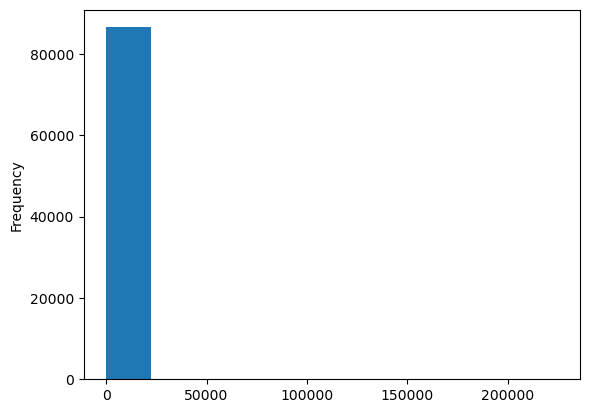

In [12]:
# Overall distribution of transaction_amount
df.transaction_amount.plot(kind='hist')

<Axes: ylabel='product_name'>

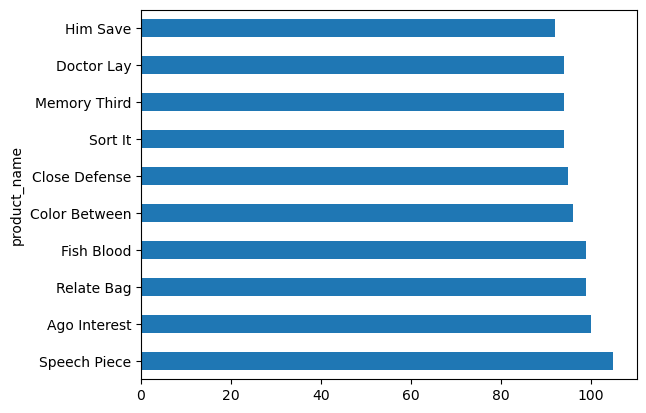

In [13]:
df.groupby('product_name').quantity.sum().sort_values(ascending=False).head(10).plot(kind='barh')

<Axes: xlabel='transaction_year'>

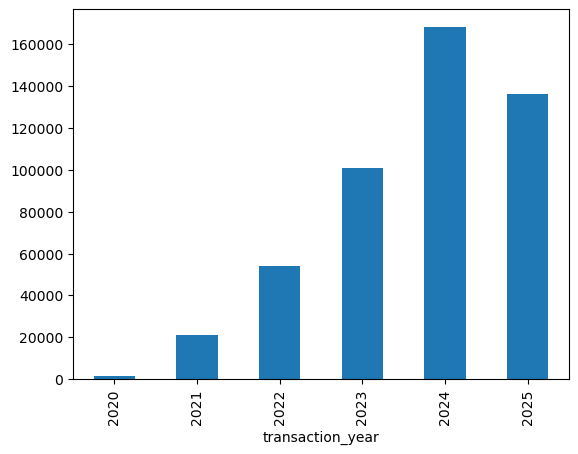

In [14]:
df['transaction_day']=df.transaction_date.dt.day_name()
df['transaction_month']=df.transaction_date.dt.month_name()
df['transaction_year']=df.transaction_date.dt.year
df.groupby('transaction_year').quantity.sum().plot(kind='bar')